# Analysis the results

In [1]:
import argparse
import datetime
import json
import random
import time
from pathlib import Path
import os, sys
import numpy as np

import torch
from torch.utils.data import DataLoader, DistributedSampler, random_split, TensorDataset
from torch import nn
import matplotlib.pyplot as plt

In [2]:
def read_one_results(path):
    with open(path, "r") as outfile:
        data = json.load(outfile)
    return data

def write_one_results(path, json_data):
    with open(path, "w") as outfile:
        json.dump(json_data, outfile)
        
def display_data_hist(loss):
    plt.hist(loss, bins=50, label='Box-based')
    plt.title('Loss Distribution')
    plt.xlabel('Loss')
    plt.ylabel('Probability Density')
    locs, _ = plt.yticks()
    plt.yticks(locs,np.round(locs/loss.shape[0],3))
    plt.legend()
    plt.show()
    
def np_read(file):
    with open(file, "rb") as outfile:
        data = np.load(outfile)
    return data
def np_write(data, file):
    with open(file, "wb") as outfile:
        np.save(outfile, data)
        
normalize_list = {"loss_bbox": [0.09300409561655773, 0.0767726528828114], "loss_ce": [0.3522786986406354, 0.7470140154753052], 
                  "loss_giou": [1.1611697194208146, 0.47297514438862676], "loss": [3.1396386155214007, 1.4399662609117525]}

## Test the performance of using only fixed number of samples

In [6]:
def LURE_weights_for_risk_estimator(weights, N):
    M = weights.size
    if M < N:
        m = np.arange(1, M+1)
        v = (
            1
            + (N-M)/(N-m) * (
                    1 / ((N-m+1) * weights)
                    - 1
                    )
            )
    else:
        v = 1

    return v

def acquire(expected_loss_inputs, samples_num, choose_num=0):
    assert samples_num <= expected_loss_inputs.size
    expected_loss = np.copy(expected_loss_inputs)
    # Log-lik can be negative.
    # Make all values positive.
    if (expected_loss < 0).sum() > 0:
        expected_loss += np.abs(expected_loss.min())
    
    if np.any(np.isnan(expected_loss)):
        logging.warning(
            'Found NaN values in expected loss, replacing with 0.')
        logging.info(f'{expected_loss}')
        expected_loss = np.nan_to_num(expected_loss, nan=0)
    pick_sample_idxs = np.zeros((samples_num), dtype = int)
    idx_array = np.arange(expected_loss.size)
    weights = np.zeros((samples_num), dtype = np.single)
    uniform_clip_val = 0.2
    for i in range(samples_num):
        expected_loss /= expected_loss.sum()
        # clip all values less than 10 percent of uniform propability
        expected_loss = np.maximum(uniform_clip_val * 1/expected_loss.size, expected_loss)
        expected_loss /= expected_loss.sum()
        # sample = np.random.multinomial(1, expected_loss)
        # cur_idx = np.where(sample)[0][0]
        cur_idx = choose_num
        pick_sample_idxs[i] = idx_array[cur_idx]
        weights[i] = expected_loss[cur_idx]
        selected_mask = np.ones((expected_loss.size), dtype=bool)
        selected_mask[cur_idx] = False
        expected_loss = expected_loss[selected_mask]
        idx_array = idx_array[selected_mask]
    return pick_sample_idxs, weights

def run_one_approximate_risk_estimator(true_losses, expected_losses, samples_num, choose_num=0):
    pick_sample_idxs, weights = acquire(expected_losses, samples_num, choose_num)
    risk_estimator_weights = LURE_weights_for_risk_estimator(weights, expected_losses.size)
    sampled_true_losses = true_losses[pick_sample_idxs]

    loss_risk = (sampled_true_losses * risk_estimator_weights).mean()
    return loss_risk

def multiple_runs(start_points, samples_num, sample_type, estimate_losses=None):
    risks = []
    for i in start_points:
        if sample_type == "mean":
            risks.append(true_losses[i:i+samples_num].mean())
        else:
            rr_estimated_risk = run_one_approximate_risk_estimator(true_losses, estimate_losses, samples_num, i)
            risks.append(rr_estimated_risk)
    return risks

In [38]:
#image_based
true_losses = np_read("./data/5_scale_31/val/pre_data/val_annotations.npy")
true_losses_mean = true_losses.mean()
rr_data = np_read("./results/MPL_loss_compare/RidgeReg_estimated_losses.npy")

In [123]:
# per = 0.01
samples_num = 5
start_points = [3963,  382, 3524, 1648, 4060, 2977, 1411, 2262, 2736,  235, 4483,
       1486, 3043,  641, 2702, 2807, 4470,  594,  107, 3858, 1035,  162,
       4034, 4494,  366, 4278, 1085, 3932, 1377, 2486, 2695, 3047, 4206,
       1269, 2686, 2035, 4253, 3059, 1996, 2325,  165, 1411, 3612, 1471,
       1622, 2724, 3290, 2737, 2308, 1086]

In [124]:
# np.random.randint(4500, size=50)

In [125]:
## random sample
mean_risks = multiple_runs(start_points, samples_num, "mean")
mean_diff = np.abs(mean_risks - true_losses_mean)
mean_diff.mean(), mean_diff.std()

(0.13014651000291663, 0.09176253045661369)

In [126]:
mean_diff

array([0.21021234, 0.08125524, 0.0781828 , 0.28498337, 0.16011138,
       0.11421336, 0.07609004, 0.35022012, 0.12345402, 0.10498539,
       0.23875868, 0.04460113, 0.21225675, 0.17265791, 0.00562468,
       0.04411266, 0.05048261, 0.06232468, 0.21245133, 0.20631605,
       0.07663399, 0.17549645, 0.01615057, 0.0537618 , 0.15292724,
       0.0425955 , 0.05267833, 0.33109624, 0.03142925, 0.00688593,
       0.23112812, 0.19506329, 0.10612848, 0.10861507, 0.0669516 ,
       0.06906172, 0.03809166, 0.26597104, 0.25069932, 0.30986075,
       0.24240195, 0.07609004, 0.05492219, 0.22378643, 0.1593738 ,
       0.07612186, 0.07262241, 0.0103663 , 0.04829573, 0.1288239 ])

In [127]:
# ridge regression
rr_risks = multiple_runs(start_points, samples_num, "ll", rr_data)
rr_diff = np.abs(rr_risks - true_losses_mean)
rr_diff.mean(), rr_diff.std()

(0.15385201419726519, 0.14544627214244019)

In [128]:
true_risks = multiple_runs(start_points, samples_num, "ll", true_losses)
true_diff = np.abs(true_risks - true_losses_mean)
true_diff.mean(), true_diff.std()

(0.011993624072516107, 0.02668103778278192)

In [136]:
perturbed_loss = true_losses + np.random.normal(loc=5.0,scale=0.01)
true_risks = multiple_runs(start_points, samples_num, "ll", perturbed_loss)
true_diff = np.abs(true_risks - true_losses_mean)
true_diff.mean(), true_diff.std()

(0.11330262076883449, 0.08328755382578279)

## distribution analysis

In [3]:
val_ce_loss = np_read("./data/5_scale_31/val/feature_pre_data/annotation_loss_ce.npy")
val_bbox_loss = np_read("./data/5_scale_31/val/feature_pre_data/annotation_loss_bbox.npy")

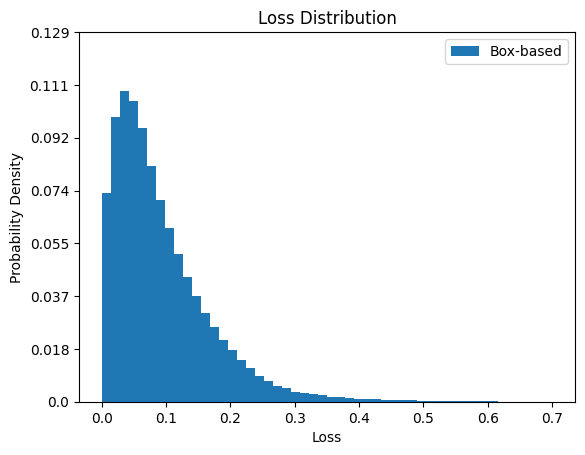

In [4]:
train_bbox_loss = np_read("./data/5_scale_31/train/feature_pre_data/annotation_loss_bbox.npy")
display_data_hist(train_bbox_loss)

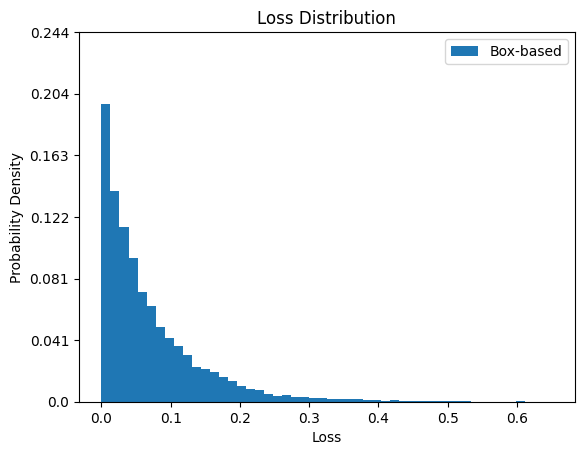

In [5]:
display_data_hist(val_bbox_loss)

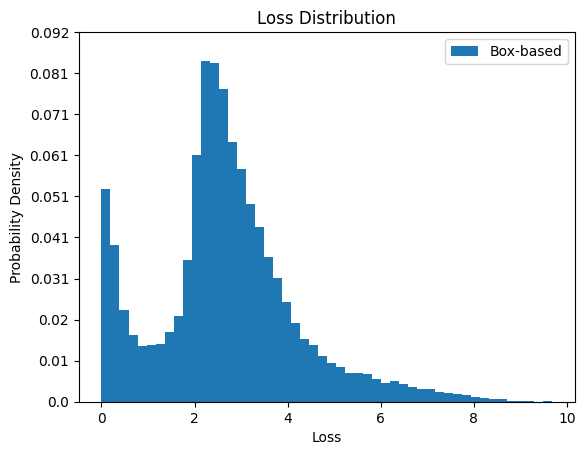

In [6]:
val_loss = np_read("./data/5_scale_31/val/feature_pre_data/annotation.npy")
display_data_hist(val_loss)

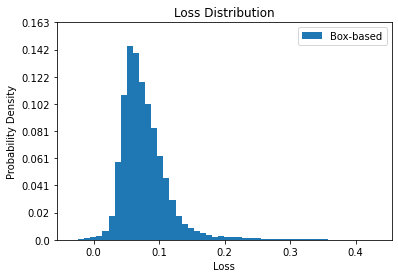

In [28]:
estimate_bbox_loss = np.array(read_one_results("/workspace/ViT-pytorch/output/ViT-feature-Nearest-train-60000-bbox-loss_losses.json")['losses'])
estimate_bbox_loss = estimate_bbox_loss * normalize_list['loss_bbox'][1] + normalize_list['loss_bbox'][0]
display_data_hist(estimate_bbox_loss)

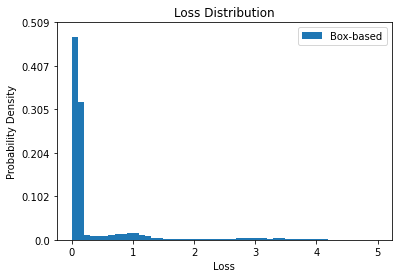

In [29]:
display_data_hist(val_ce_loss)

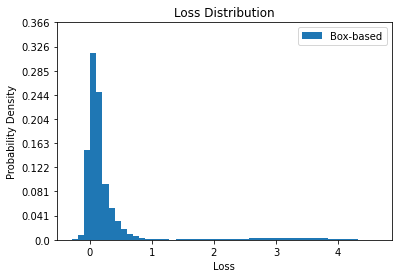

In [30]:
estimate_bbox_loss = np.array(read_one_results("/workspace/ViT-pytorch/output/ViT-feature-Nearest-train-60000-class-loss_losses.json")['losses'])
estimate_bbox_loss = estimate_bbox_loss * normalize_list['loss_ce'][1] + normalize_list['loss_ce'][0]
display_data_hist(estimate_bbox_loss)

In [14]:
val_bbox_loss.min(), val_bbox_loss.max(), val_bbox_loss.mean()

(0.0, 0.65130215883255, 0.0695277584490669)

In [17]:
train_bbox_loss = np_read("./data/5_scale_31/train/feature_pre_data/annotation_loss_bbox.npy")
train_bbox_loss.min(), train_bbox_loss.max(), train_bbox_loss.mean(), train_bbox_loss.std()

(0.0, 0.7006464004516602, 0.09300409561655773, 0.0767726528828114)

In [18]:
train_bbox_loss = np_read("./data/5_scale_31/train/feature_pre_data/annotation_loss_ce.npy")
train_bbox_loss.min(), train_bbox_loss.max(), train_bbox_loss.mean(), train_bbox_loss.std()

(1.2622098211068078e-06,
 5.230670928955078,
 0.3522786986406354,
 0.7470140154753052)

In [19]:
train_bbox_loss = np_read("./data/5_scale_31/train/feature_pre_data/annotation_loss_giou.npy")
train_bbox_loss.min(), train_bbox_loss.max(), train_bbox_loss.mean(), train_bbox_loss.std()

(0.0, 1.9994348287582397, 1.1611697194208146, 0.47297514438862676)

In [20]:
train_bbox_loss = np_read("./data/5_scale_31/train/feature_pre_data/annotation.npy")
train_bbox_loss.min(), train_bbox_loss.max(), train_bbox_loss.mean(), train_bbox_loss.std()

(4.744050329463789e-06,
 10.388030052185059,
 3.1396386155214007,
 1.4399662609117525)

In [7]:
val_path = "./data/5_scale_31/val/feature_pre_data/annotation.npy"
val_losses = np_read(val_path)
train_path = "./data/5_scale_31/train/feature_pre_data/annotation.npy"
train_losses = np_read(train_path)

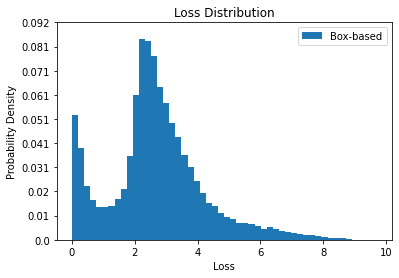

In [8]:
display_data_hist(val_losses)

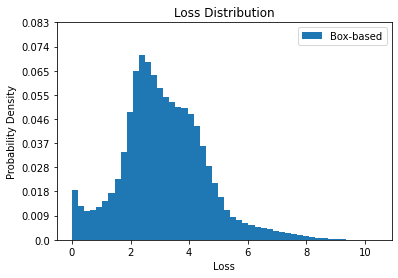

In [9]:
display_data_hist(train_losses)

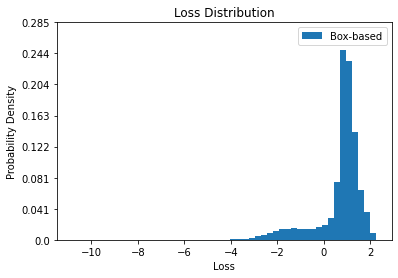

In [10]:
display_data_hist(np.log(val_losses))

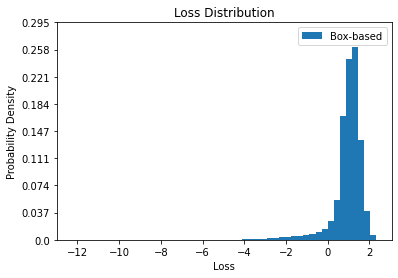

In [11]:
display_data_hist(np.log(train_losses))

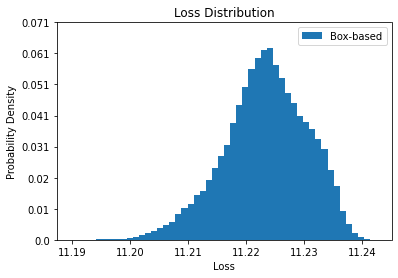

In [12]:
estimate_bbox_loss = np.array(read_one_results("/workspace/ViT-pytorch/output/ViT-feature-Nearest-train-60000-grad-norm_losses.json")['losses'])
# estimate_bbox_loss = estimate_bbox_loss * normalize_list['loss'][1] + normalize_list['loss'][0]
display_data_hist(estimate_bbox_loss)

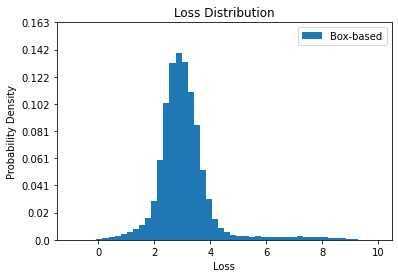

In [33]:
val_path = "/workspace/ViT-pytorch/output/ViT-feature-train-60000_losses.json"
feature_vit_losses = np.array(read_one_results(val_path)["losses"])
display_data_hist(feature_vit_losses)

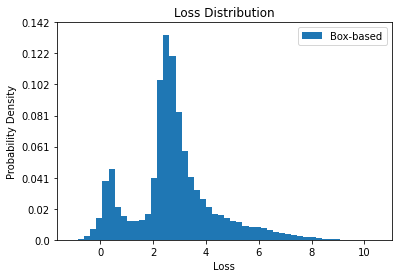

In [24]:
val_path = "/workspace/ViT-pytorch/output/ViT-feature-train-with-test_losses.json"
feature_vit_losses = np.array(read_one_results(val_path)["losses"])
display_data_hist(feature_vit_losses)

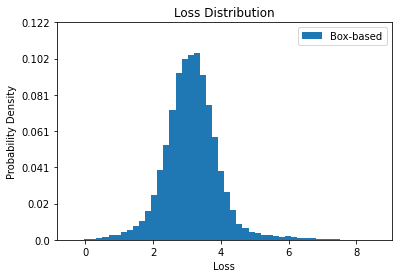

In [25]:
val_path = "./results/loss_analysis/box_based_ridge_regression_feature.npy"
feature_vit_losses = np_read(val_path)
display_data_hist(feature_vit_losses)

In [3]:
results_path = "./results/loss_analysis/"
i_ase_results = read_one_results(results_path + "image_based_ASE.json")
i_rr_results = read_one_results(results_path + "image_based_redge_regression.json")
b_rr_results = read_one_results(results_path + "box_based_redge_regression.json")
image_true_loss = np.array(i_rr_results['true loss'])
box_true_loss = np.array(b_rr_results['true loss'])
i_ase_loss = np.array(i_ase_results['estimated loss'])
i_rr_loss = np.array(i_rr_results['estimated loss'])
b_rr_loss = np.array(b_rr_results['estimated loss'])

In [5]:
vit_path = "/workspace/ViT-pytorch/output/"
estimated_loss_path = vit_path + "ViT-train-with-test_retrain_losses.json"
b_vit_test_loss = np.array(read_one_results(estimated_loss_path)['losses'])
b_vit_loss = np.array(read_one_results(vit_path + "ViT-train-20000_losses.json")['losses'])

In [6]:
def transf_to_percetage(values):
    return values / values.sum()
image_true_loss_p = transf_to_percetage(image_true_loss)
box_true_loss_p = transf_to_percetage(box_true_loss)
i_ase_loss_p = transf_to_percetage(i_ase_loss)
i_rr_loss_p = transf_to_percetage(i_rr_loss)
b_rr_loss_p = transf_to_percetage(b_rr_loss)
b_vit_loss_p = transf_to_percetage(b_vit_loss)

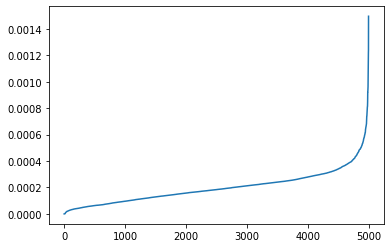

In [24]:
image_true_loss_p_sort = np.sort(image_true_loss_p)
plt.plot(np.arange(image_true_loss_p_sort.shape[0]), image_true_loss_p_sort)
plt.show()

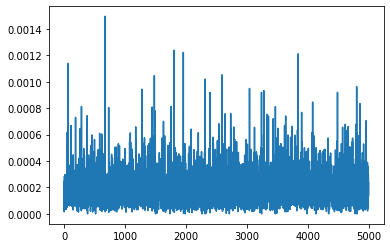

In [27]:
plt.plot(np.arange(image_true_loss_p.shape[0]), image_true_loss_p)
plt.show()

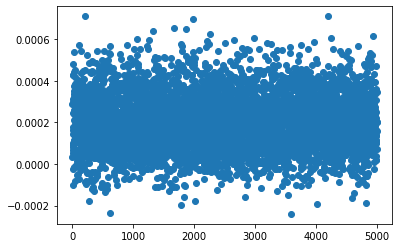

In [27]:
plt.scatter(np.arange(image_true_loss_p.shape[0]), i_rr_loss_p)
plt.show()

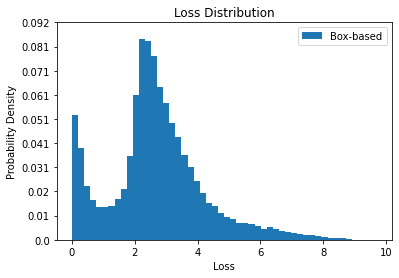

In [8]:
display_data_hist(box_true_loss)

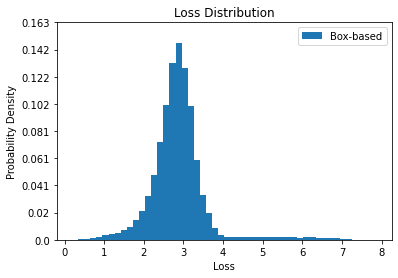

In [9]:
display_data_hist(b_vit_loss)

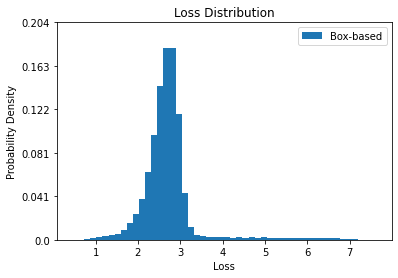

In [11]:
display_data_hist(b_vit_test_loss)

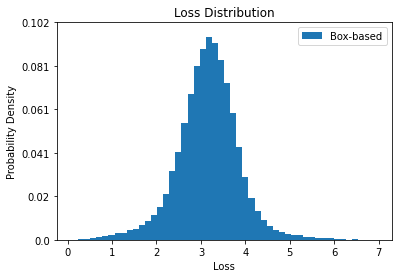

In [10]:
display_data_hist(b_rr_loss)

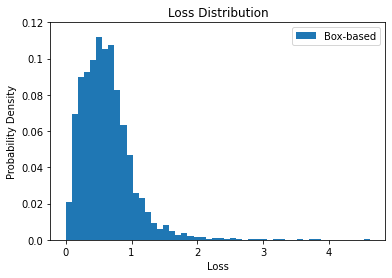

In [30]:
plt.hist(image_true_loss, bins=50, label='Box-based')
plt.title('Loss Distribution')
plt.xlabel('Loss')
plt.ylabel('Probability Density')
locs, _ = plt.yticks()
plt.yticks(locs,np.round(locs/image_true_loss.shape[0],3))
plt.legend()
plt.show()

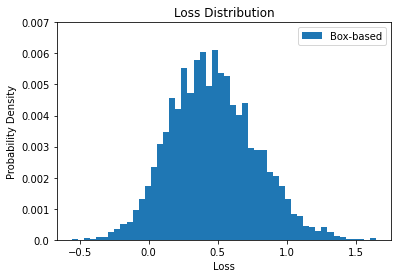

In [31]:
plt.hist(i_rr_loss, bins=50, label='Box-based')
plt.title('Loss Distribution')
plt.xlabel('Loss')
plt.ylabel('Probability Density')
locs, _ = plt.yticks()
plt.yticks(locs,np.round(locs/b_rr_loss.shape[0],3))
plt.legend()
plt.show()

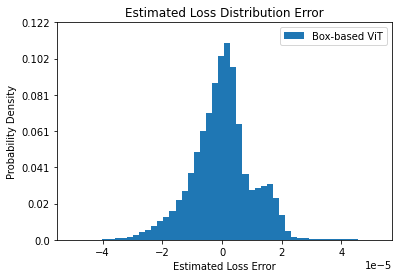

In [11]:
b_vit_loss_error = b_vit_loss_p - box_true_loss_p
plt.hist(b_vit_loss_error, bins=50, label='Box-based ViT')
plt.title('Estimated Loss Distribution Error')
plt.xlabel('Estimated Loss Error')
plt.ylabel('Probability Density')
locs, _ = plt.yticks()
plt.yticks(locs,np.round(locs/b_vit_loss_error.shape[0],3))
plt.legend()
plt.show()

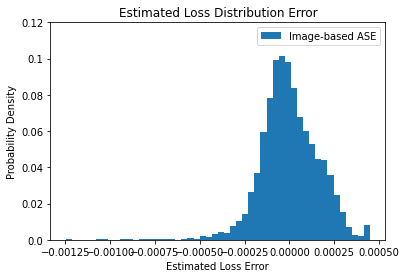

In [8]:
i_ase_loss_error = i_ase_loss_p - image_true_loss_p
i_rr_loss_error = i_rr_loss_p - image_true_loss_p
b_rr_loss_error = b_rr_loss_p - box_true_loss_p
plt.hist(i_ase_loss_error, bins=50, label='Image-based ASE')
# plt.hist(i_rr_loss_error, bins=50, label='Image-based RR')
# plt.hist(b_rr_loss_error, bins=50, label='Box-based RR')
plt.title('Estimated Loss Distribution Error')
plt.xlabel('Estimated Loss Error')
plt.ylabel('Probability Density')
locs, _ = plt.yticks()
plt.yticks(locs,np.round(locs/i_ase_loss_error.shape[0],3))
plt.legend()
plt.show()

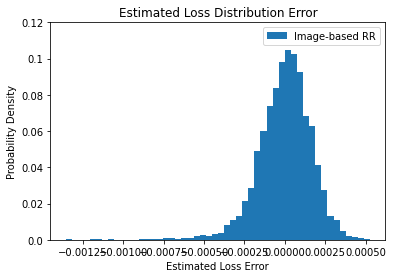

In [9]:
plt.hist(i_rr_loss_error, bins=50, label='Image-based RR')
plt.title('Estimated Loss Distribution Error')
plt.xlabel('Estimated Loss Error')
plt.ylabel('Probability Density')
locs, _ = plt.yticks()
plt.yticks(locs,np.round(locs/i_ase_loss_error.shape[0],3))
plt.legend()
plt.show()

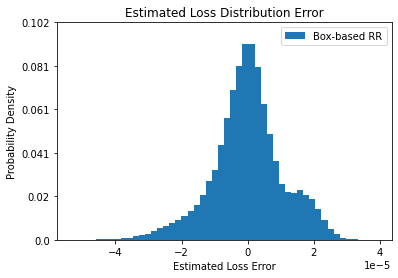

In [10]:
plt.hist(b_rr_loss_error, bins=50, label='Box-based RR')
plt.title('Estimated Loss Distribution Error')
plt.xlabel('Estimated Loss Error')
plt.ylabel('Probability Density')
locs, _ = plt.yticks()
plt.yticks(locs,np.round(locs/b_rr_loss_error.shape[0],3))
plt.legend()
plt.show()

In [16]:
np.absolute(b_rr_loss_error).sum()

0.39624252760459194

In [17]:
np.absolute(i_rr_loss_error).sum()

0.6204263944291746

In [18]:
np.absolute(i_ase_loss_error).sum()

0.6099535208952915

In [20]:
np.absolute(b_rr_loss_error).mean()

8.06534893046046e-06

In [21]:
np.absolute(i_rr_loss_error).mean()

0.0001240852788858349

In [22]:
np.absolute(i_ase_loss_error).mean()

0.0001219907041790583